In [1]:
# Mount Google drive for save and load LSTM models if you're using colab 
# , and if your files are saved in Google drive
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')
    
else:
  print('Not running on Colab')

Running on Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import time

# For LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model

# For scipy minimize
from scipy.optimize import minimize

In [3]:
# Load model files (LSTM and MinMaxScaler)
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  model = load_model('/content/drive/MyDrive/LSTM_MPC/FOPDT/model.h5')
  s1 = joblib.load('/content/drive/MyDrive/LSTM_MPC/FOPDT/s1.sav')
  s2 = joblib.load('/content/drive/MyDrive/LSTM_MPC/FOPDT/s2.sav')
  
else:
  print('Not running on Colab')
  model = load_model('model.h5')
  s1 = joblib.load('s1.sav')
  s2 = joblib.load('s2.sav')

Running on Colab


In [4]:
def MPCobj(u_hat, y_hat, SP_hat, u, y, SP, window, P, M):
  u_hat_P = np.ones(P-M) * u_hat[-1] # future u values after the control horizon
  u_all = np.concatenate((u, u_hat, u_hat_P),axis=None)
  y_all = np.append(y, y_hat)

  X = np.transpose([u_all,y_all]) 
  # print(X)
  Y = np.transpose([y_all])
  # print(Y)
  SP_trans = np.transpose([SP_hat])

  Xs = s1.transform(X)
  # print(Xs)
  Ys = s2.transform(Y)
  # print(Ys)
  SPs = s2.transform(SP_trans)

  # Appending the window (past) and Prediction (future) arrays
  Xsq = Xs.copy()
  Ysq = Ys.copy()
  # SPsq = np.reshape(SP_pred, (P,Ys.shape[1]))
  # for i in range(window,len(Xsq)):
  #     Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
  #     # LSTM prediction
  #     Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model.predict(Xin) 
  #     # (Xs.shape[1]-Ys.shape[1]) indicates the index of the column for the 
  #     # first 'system' output variable in the 'LSTM' input array
  #     Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]

  Xin = Xsq.reshape((1, window+P, np.shape(Xsq)[1]))
  Ysq = model(Xin)
  # print(Ysq)
  
  Ytu = s2.inverse_transform(Ysq)
  Xtu = s1.inverse_transform(Xsq)

  u_hat0 = np.append(u[-1], u_hat)
  pred["y_hat"] = Ytu[0]
  pred["u_hat"] = Xtu[window:,0]

  Obj = 10*np.sum((pred["y_hat"] - SP_hat)**2) + np.sum(((u_hat0[1:] - u_hat0[0:-1])**2))

  return Obj

In [5]:
window = 5 # Window (for past values)
P = 10 # Prediction Horizon (for CV)
M = 4 # Control Horizon (for MV)

In [6]:
# Values at time=k- (past)
u = np.ones(window) * 0.5
y = np.ones(window) * 0
SP = np.ones(window) * 1 # Setpoint

# Initial Values at time=k+ (in prediction horizon)
t_hat = np.linspace(0,P-1,P)
u_hat = np.ones(M) * u[-1]
y_hat = np.ones_like(t_hat) * y[-1]
SP_hat = np.ones_like(t_hat) * SP[-1]

# for result storage
pred = {
    "y_hat": np.ones_like(t_hat) * y[-1],
    "u_hat": np.ones_like(t_hat) * u[-1]
    }

In [7]:
A = MPCobj(u_hat, y_hat, SP_hat, u, y, SP, window, P, M)

In [8]:
A

28.658282305271243

In [9]:
pred['u_hat']

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [10]:
pred['y_hat']

array([0.37478411, 0.4432423 , 0.46141947, 0.46232869, 0.47701566,
       0.48461544, 0.48869108, 0.48556422, 0.48461158, 0.49506963])

In [11]:
t0 = time.time()
solution = minimize(MPCobj, u_hat, method='SLSQP',args=(y_hat, SP_hat, u, y, SP, window, P, M),options={'eps': 1e-06, 'ftol': 1e-01})
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

Runtime: 0.41 s


In [12]:
print(solution)

     fun: 2.1839714108444053
     jac: array([0.46001939, 0.04167945, 0.51776786, 0.51532104])
 message: 'Optimization terminated successfully.'
    nfev: 41
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([1.32442783, 1.51098558, 1.3838241 , 0.99806476])


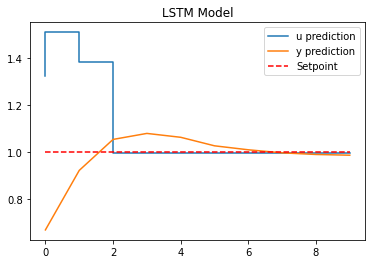

In [13]:
plt.figure()
plt.title("LSTM Model")
plt.step(t_hat,pred["u_hat"], label='u prediction')
plt.plot(t_hat,pred["y_hat"], label='y prediction')
plt.plot(t_hat,SP_hat, 'r--', label='Setpoint')
plt.legend()
plt.show()